# Heart Failure Prediction Analysis

- **Binary classification** task where the goal is to predict whether patient had a heart disease event or not based on 11 clinical features.
- Authors: David Poslušný, Jiří Dragoun.
- Source: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

### Import libraries

In [68]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
#Why is this here? It is simple, when you run this notebook at jupyter.vse.cz, scikit-learn will throw a few warnings while doing GridSearchCV (wrong combinations).
#There are two solutions. We could specify by hand which combinations are allowed and which are not, but this kind of defeats the whole purpose of GridSearch. 
#Our other option is to just simply surpress those warnings.
#If you comment the code above this comment, everything will still work as expected, but it will be a bit messy (printing of warnings to the notebook).

#All things considered we recommend to run this notebook locally, it runs faster (even on old i5 with 16GBs of RAM) and you have full control over the environment. 
#If you really want to run this notebook on jupyter.vse.cz, we highly recomment to surpress warnings, which saves minute or two of runtime. 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
colour = sns.color_palette("Set2")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_curve, RocCurveDisplay, roc_auc_score, f1_score, precision_score, recall_score

# 1. Dataset Description

### Heart Failure Prediction Dataset

11 clinical features for predicting heart disease events.

Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worldwide. Four out of five CVD deaths are due to heart attacks and strokes, and one-third of these deaths occur prematurely in people under 70 years of age. Heart failure is a common event caused by CVDs. This dataset contains 11 features that can be used to predict a possible heart disease.

People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management where various machine learning models can be of a great use.

This dataset was created by combining different datasets already available independently but not combined before. In this dataset, 5 heart datasets are combined over 11 common features which makes it the largest heart disease dataset available so far for research purposes. The five datasets used for its curation are:
- Cleveland: 303 observations
- Hungarian: 294 observations
- Switzerland: 123 observations
- Long Beach VA: 200 observations
- Stalog (Heart) Data Set: 270 observations

Total: 1190 observations

Duplicated: 272 observations

Final dataset: 918 observations

## Loading Dataset

In [3]:
df = pd.read_csv('heart.csv')

In [4]:
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


First look at the data suggest that the dataset is complete i.e. no values are missing. But let's verify it with an appropriate command.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


As mentioned in the introduction of this chapter, the original dataset had 1190 records, of which 272 were duplicates. Authors then cleaned the data of any duplicates, so the final number of records without any missing values is 918, as shown by `df.info()` command.

Since there are no missing values, we won't need to handle this kind of preprocessing.

In [6]:
df.shape

(918, 12)

There are a total of 12 columns, 11 of which are features and 1 is the target variable.

## Numerical data
In the table below is the statistical report about numerical data in the dataset.

For numerical data we can calculate several measures of central tendencies such as mean, median or different quantiles. For measures of variability, we can for example calculate range, variance or standard deviation.

Pandas dataframe method `df.describe()` provides a quick report on descriptive statistics that include those that summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values.

Using these statistics, we can assess the validity of the input and check for possible outliers or values that do not make sense in this context. Attributes with values equal to zero where value of zero does not make sense are analyzed and solution for dealing with those rows is discussed.

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


Summary statistics table shows that we have total of 7 numerical attributes.

We can also look at correlations between these numerical features using the `df.corr()` function.

In [7]:
df.corr(numeric_only=True)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
Age,1.000000,0.254399,-0.095282,0.198039,-0.382045,0.258612,0.282039
RestingBP,0.254399,1.000000,0.100893,0.070193,-0.112135,0.164803,0.107589
Cholesterol,-0.095282,0.100893,1.000000,-0.260974,0.235792,0.050148,-0.232741
FastingBS,0.198039,0.070193,-0.260974,1.000000,-0.131438,0.052698,0.267291
MaxHR,-0.382045,-0.112135,0.235792,-0.131438,1.000000,-0.160691,-0.400421
Oldpeak,0.258612,0.164803,0.050148,0.052698,-0.160691,1.000000,0.403951
HeartDisease,0.282039,0.107589,-0.232741,0.267291,-0.400421,0.403951,1.000000


It seems there are a lot of very weak positive and negative correlations. The Strongest positive correlation is between Oldpeak and target variable HeartDisease, 40 %. We can assume these two attributes will be at least somewhat related. For the strongest negative correlation, we can see it is between MaxHR and HeartDisease. From this relationship we can assume that increasing heart rate has a negative effect on the target variable. 

### Numerical data - explanation

- Age
    - The age of the patient
    - We can assume that the age will play an important role in terms of Heart Disease analysis
    - Youngest person is 28 years old, while the oldest one is 77 years old
- RestingBP 
    - Resting blood pressure (mm/Hg)
    - This attribute should not be zero ie. zero means missing value 
    - Next minimum value after zero is 80, maximum value is 200 which suggests that BP is the Systolic BP as shown in the figure below.
    - Only one row has BP equal to zero
- Cholesterol
    - Serum cholesterol (mm/dl)
    - This feature should not also be zero
    - A lot of rows (172) have value of cholesterol equal to zero, which is over 10% of our dataset 
    - It is necessary to come up with technique to alter these values, because deleting that many rows is possible but not desirable in our analysis
- FastingBS
    - Fasting blood sugar
    - This is a binary feature 
    - Zero means FastingBS <= 120mg/dl
    - Value one means FastingBS > 120 mg/dl
    - In this case rows with zero are valid, but it is unfortunate that the dataset does not have the detail on this column
    - In this context we can work with this numerical attribute as a categorical attribute
- MaxHR
    - Maximum heart rate achieved
    - This attribute takes on values between 60 and 202
    - All rows seem to be valid
- Oldpeak
    - oldpeak ST measured in depression
    - ST depression caused by activity in comparison to rest
    - ST depression refers to a finding on an electrocardiogram wherein the trace in the ST segment is abnormally low below the baseline
    - All values in dataset appear to be permissible (-2.6; 6.2)
- HeartDisease
    - If the patient suffers from heart disease (binary - 1 = True; 0 = False)
    - In this context we can work with this numerical attribute as a categorical attribute
#### RestingBP - figure 

![BP_range](img/BP_range.jpg)

#### Cholesterol - figure
![Cholesterol_range](img/Cholesterol_range.jpg)

In [8]:
print(f"Range of BP is: {df[df['RestingBP'] > 0]['RestingBP'].min()} - {df['RestingBP'].max()}")
print("According to the figure above, RestingBP column should represent Systolic BP.")
print(f"Number of rows where RestingBP is zero: {len(df[df['RestingBP'] == 0])}\n")
print(f"One row is not a deal breaker, so we can potentially delete it or use an imputation.\n\n")

print(f"Range of Cholesterol is: {df[df['Cholesterol'] > 0]['Cholesterol'].min()} - {df['Cholesterol'].max()}")
print("Values of 85 are dangerously low, while values of 603 are extremely high.")
print(f"Number of rows where Cholesterol is zero: {len(df[df['Cholesterol'] == 0])}")


Range of BP is: 80 - 200
According to the figure above, RestingBP column should represent Systolic BP.
Number of rows where RestingBP is zero: 1

One row is not a deal breaker, so we can potentially delete it or use an imputation.


Range of Cholesterol is: 85 - 603
Values of 85 are dangerously low, while values of 603 are extremely high.
Number of rows where Cholesterol is zero: 172


## Categorical data
Now let's look at the categorical data in our dataset. Since we cannot really calculate any statistics on categorical data apart from mode, we will firstly look at all the unique values in those columns. 

The code below uses a technique that basically gets all the columns that weren't included in the summary of descriptive statistics, so all non-numerical categorical attributes. For these attributes, we are going to show all the possible values as well as their modal category (the most frequent value in the feature).

In [9]:
non_numeric_cols = df.columns.difference(df.describe().columns)
print("Categorical data and their unique values:\n")
print("--- Unique values ---")
print(pd.Series({c: df[c].unique() for c in df[non_numeric_cols]}))
print("\n\n--- Modal categories ---")
print(df[non_numeric_cols].mode().T)

Categorical data and their unique values:

--- Unique values ---
ChestPainType     [ATA, NAP, ASY, TA]
ExerciseAngina                 [N, Y]
RestingECG          [Normal, ST, LVH]
ST_Slope             [Up, Flat, Down]
Sex                            [M, F]
dtype: object


--- Modal categories ---
                     0
ChestPainType      ASY
ExerciseAngina       N
RestingECG      Normal
ST_Slope          Flat
Sex                  M


In [10]:
df[non_numeric_cols].shape[1]

5

The dataset contains a total of 5 categorical non-numerical attributes. All of these attributes will need to be pre-proccesed and converted into numerical features before doing any data mining.

### Categorical data - explanation
- ChestPainType
    - Chest pain type (TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic)
    - Pain can suggest some health issues
    - Most people from the data have ASY
- ExerciseAngina 
    - Exercise-induced angina (Y: Yes, N: No)
    - This is a binary feature
    - Angina is pain in the chest that comes on with exercise, stress, or other things that make the heart work harder
    - It is an extremely common symptom of coronary artery disease, which is caused by cholesterol-clogged coronary arteries
    - Most frequent values is NO
- RestingECG
    - Resting electrocardiogram results, values are explained below
    - Normal: Normal
    - ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria
    - Modal category is 'normal'
- ST_Slope
    - The slope of the peak exercise ST segment (Up: upsloping, Flat: flat, Down: downsloping)
    - Modal category is 'flat'
- Sex
   - Sex of the patient (M: Male, F: Female)
   - Most patients were male

# 2. Exploratory Data Analysis

In this chapter we will perform an exploratory data analysis on the provided dataset.

## Visualization of categorical data


For visualizing categorical data, we will use bar charts.

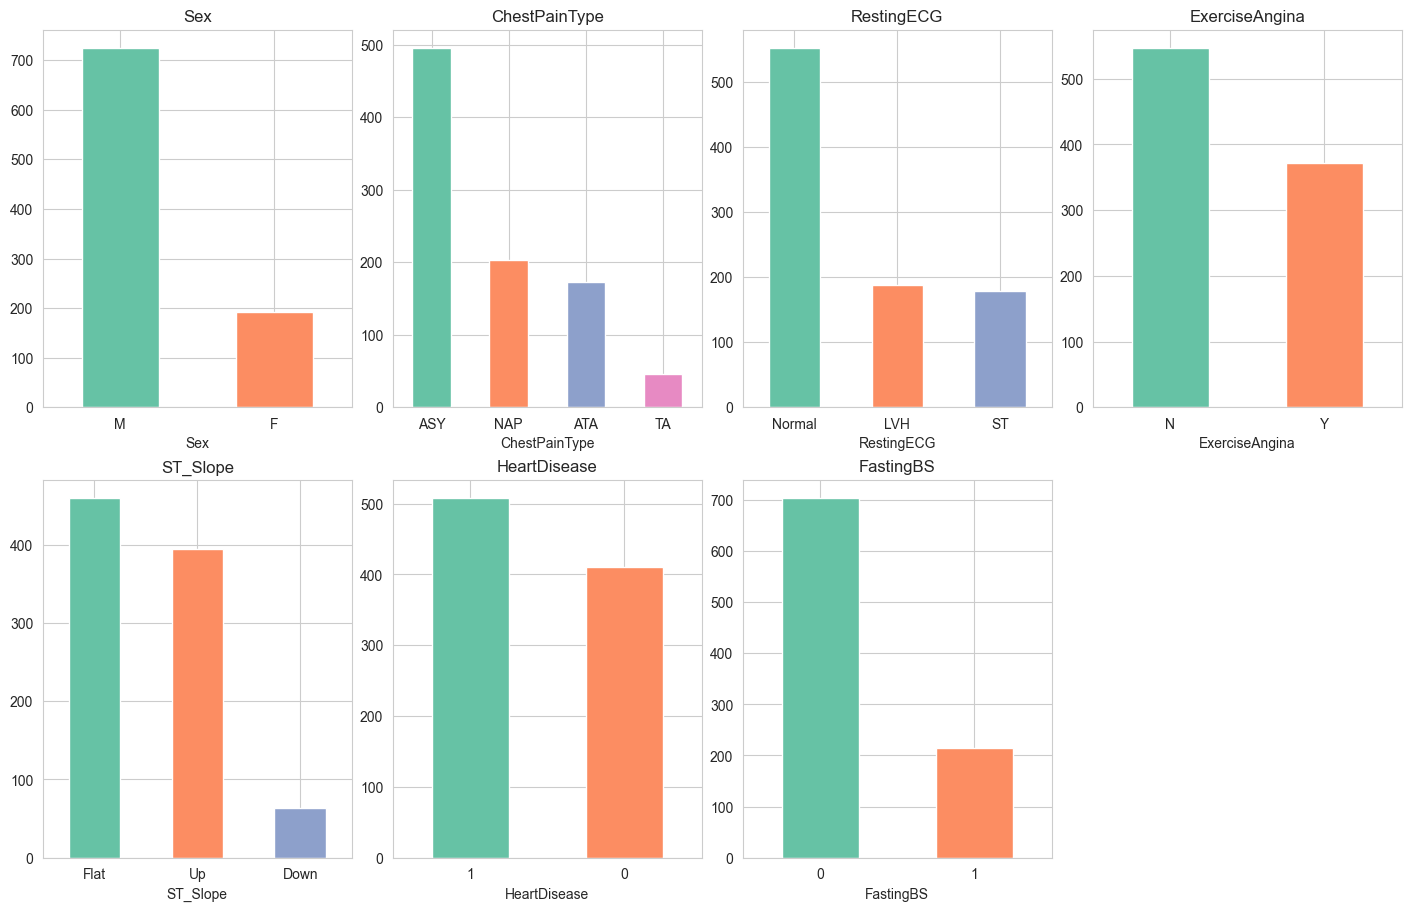

In [11]:
visualise_cols = [["Sex", "ChestPainType", "RestingECG", "ExerciseAngina"],["ST_Slope", "HeartDisease", "FastingBS"]]
fig, ax = plt.subplots(nrows=2, ncols=4, constrained_layout=True, figsize=(14, 9))
sns.set()
for ir, row in enumerate(visualise_cols):
    for ic, cat in enumerate(row):
        df[cat].value_counts().plot(kind="bar", color = colour, ax=ax[ir,ic], title = f"{cat}", rot=0)
fig.delaxes(ax[1][3])

From the visualization, we can see that the Sex attribute is imbalanced, as most patients were male. Same goes for attributes ChestPainType, RestingECG and FastingBS where categories ASY, Normal and Y respectively are the most frequent ones in the attributes.

Attributes ExerciseAngina, ST_Slope and HeartDisease seems to be fairly balanced.

## Visualization of numerical data
For visualizing continuous numerical attributes, we will use histograms with 12 bins.

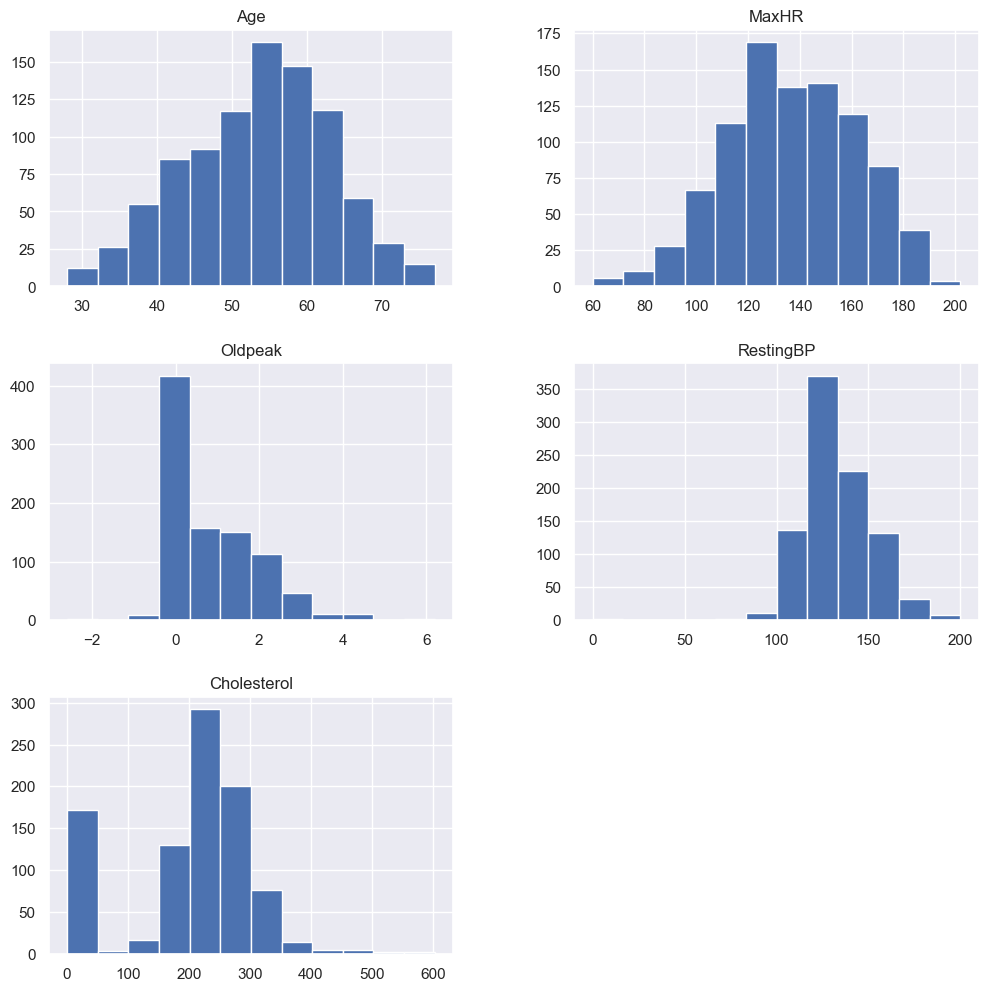

In [13]:
numerical_cols = ["Age", "MaxHR", "Oldpeak", "RestingBP", "Cholesterol"]
df[numerical_cols].hist(figsize=(12, 12), bins=12)
plt.show()

From the results, we can see that Age is resembling a fair normal distribution of values. Same could be said for MaxHR, although the distribution is a bit skewed. For attribute Oldpeak most values are centred around zero. RestingBP is also very close to normal distribution.

From the Cholesterol attribute we can now see that indeed a lot of values are zero, which is not permitted and likely means that 0 was a missing value. We will need to impute all zeros with either mean or median later.

Let's visualize the attribute Cholesterol further by using a boxplot, which will clearly show us how many outliers there actually are.

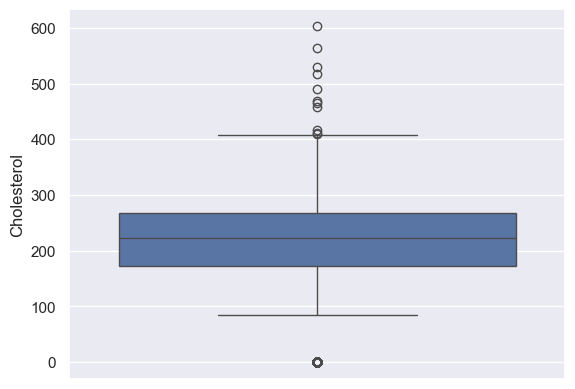

In [14]:
sns.boxplot(data=df['Cholesterol'])
plt.show()

It is now even more clear that this attribute is problematic. There are many outliers below minimum, as we have already pointed out earlier, these are the values 0. But it also seems that a lot of values are above maximum, scaling up to and above 600, which is clearly skewing the variance of the variable.

## Aggregation of data - discovering hidden information
In this section of EDA, we will create aggregations of data and visualize the results in corresponding graphs.

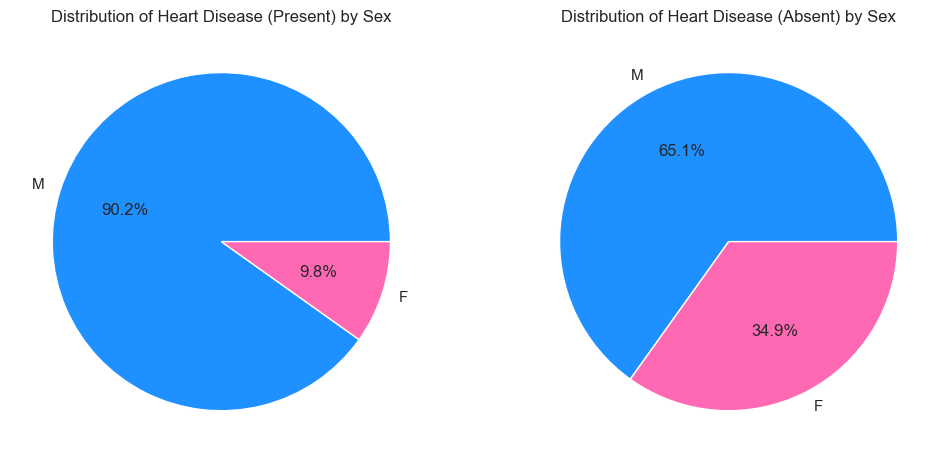

In [15]:
hd_agg_1 = df[df['HeartDisease'] == 1]
hd_agg_0 = df[df['HeartDisease'] == 0]
gender_agg_1 = hd_agg_1['Sex'].value_counts()
gender_agg_0 = hd_agg_0['Sex'].value_counts()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

gender_agg_1.plot(kind='pie', autopct='%1.1f%%', colors=['dodgerblue', 'hotpink'], ax=axes[0])
axes[0].set_title('Distribution of Heart Disease (Present) by Sex')
axes[0].set_ylabel('')

gender_agg_0.plot(kind='pie', autopct='%1.1f%%', colors=['dodgerblue', 'hotpink'], ax=axes[1])
axes[1].set_title('Distribution of Heart Disease (Absent) by Sex')
axes[1].set_ylabel('')

plt.show()

From these two pie charts, we can observe that over 90 % of patients that had a heart disease were male. For the patients that did not have a heart disease, the ratio is less drastic. Over two thirds (65.1 %) of patients were also male.

Normally, this finding would be quite significant, but since we had previously seen that the dataset is heavily imbalanced by gender, where more than 700 patients are male. So this ratio is more than logical.

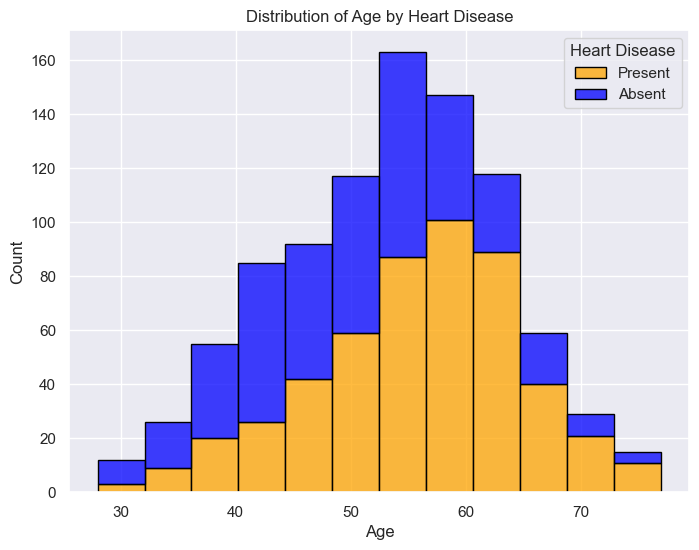

In [16]:
sns.set()
plt.figure(figsize=(8, 6))
agg_data = pd.concat([df[df['HeartDisease'] == 1], df[df['HeartDisease'] == 0]])

sns.histplot(
    data=agg_data, 
    x='Age', 
    hue='HeartDisease', 
    bins=12, 
    multiple='stack', 
    palette=['blue', 'orange'], 
    edgecolor='black'
)

plt.title('Distribution of Age by Heart Disease')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(title='Heart Disease', labels=['Present', 'Absent'])
plt.show()

This histogram shows distribution of age by heart disease. From the graph, we can see that older people tend to have increased chance of getting a heart disease, as can be seen by the height of the yellow part of the bin. This is a logical and well known fact which only solidifies the quality of the data. Other than that, there are no clear outliers in terms of age by heart disease.

Now let's calculate descriptive statistics for the whole dataset, but aggregated by Sex and HeartDisease.

In [17]:
df_full_agg_sex = df.groupby('Sex').agg({
    'Age': pd.Series.mean,
    'ChestPainType': pd.Series.mode,
    'RestingBP': pd.Series.mean,
    'Cholesterol': pd.Series.mean,
    'FastingBS': pd.Series.mode,
    'RestingECG': pd.Series.mode,
    'MaxHR': pd.Series.mean,
    'ExerciseAngina': pd.Series.mode,
    'Oldpeak': pd.Series.mode,
    'ST_Slope': pd.Series.mode,
    'HeartDisease': pd.Series.mode,
})
df_full_agg_sex

,Age,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
Sex,,,,,,,,,,,
F,52.492228,ASY,132.212435,241.196891,0,Normal,146.139896,N,0.0,Up,0
M,53.782069,ASY,132.445517,187.513103,0,Normal,134.325517,N,0.0,Flat,1


As seen by the table, even though there are way more men than women in the dataset, there are no clear differences between the two genders. Cholesterol is skewed attribute at the moment, so it is hard to evaluate  these values.

In [18]:
df_full_agg_hd = df.groupby('HeartDisease').agg({
    'Age': pd.Series.mean,
    'Sex': pd.Series.mode,
    'ChestPainType': pd.Series.mode,
    'RestingBP': pd.Series.mean,
    'Cholesterol': pd.Series.mean,
    'FastingBS': pd.Series.mode,
    'RestingECG': pd.Series.mode,
    'MaxHR': pd.Series.mean,
    'ExerciseAngina': pd.Series.mode,
    'Oldpeak': pd.Series.mode,
    'ST_Slope': pd.Series.mode,
})
df_full_agg_hd

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
HeartDisease,,,,,,,,,,,
0,50.551220,M,ATA,130.180488,227.121951,0,Normal,148.151220,N,0.0,Up
1,55.899606,M,ASY,134.185039,175.940945,0,Normal,127.655512,Y,0.0,Flat


Aggregation by HeartDisease gives way more interesting results. It seems that people that have a heart disease are on average 5 years older. Other than that, values are similar.

Now let's look at relationship between Max HR and Age attributes.

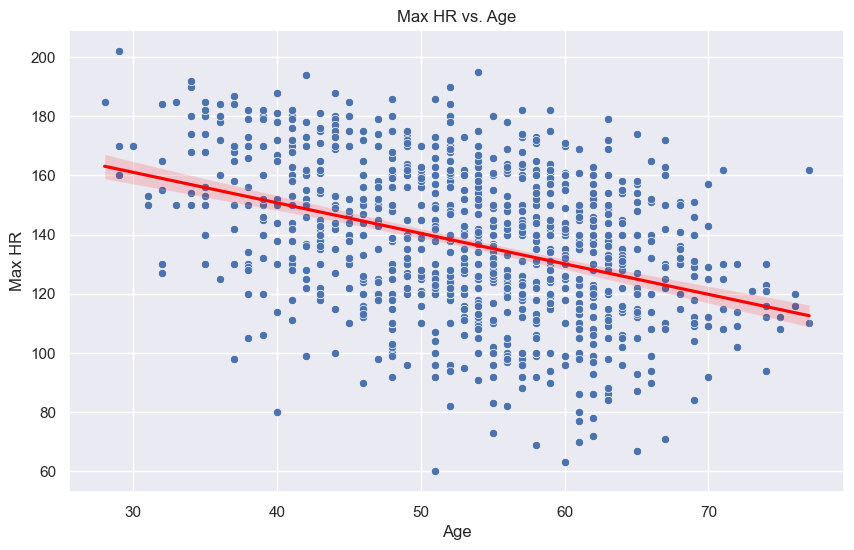

Correlation between Max HR and Age is -0.38


In [19]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Age', y='MaxHR')
sns.regplot(data=df, x='Age', y='MaxHR', scatter=False, color='red')

plt.title('Max HR vs. Age')
plt.xlabel('Age')
plt.ylabel('Max HR')
plt.show()

print("Correlation between Max HR and Age is " + str(round(df['Age'].corr(df['MaxHR']), 2)))

From the scatter plot it seems that Max HR and Age have negative correlation, meaning as you age, your max heart rate should lower. That makes perfect sense.

### Take aways
Based on the findings above, we can determine that older people who achieve lower max heart rates are more prone to have heart disease. The data also suggest that men are more likely to have a heart disease. But we need to take this claim with a pinch of salt, keeping in mind that this dataset contains more man then woman.

## 3. Data Preprocessing

In this chapter we will perform data preprocessing which will include these tasks: 
- **train and test split**
  - splitting data into sets for model fitting and model evaluation
- **attribute recoding**
  - creating new columns based on one-hot encoding
- **handling outliers**
  - dealing with senseless ("missing") values and imputing them
- **data normalization**
  - normalizing data into same scales

### Train Test Split
Dataset will be split into train and test set with ratio of 80/20.

In [20]:
X_train, X_test, y_train, y_test  = train_test_split(df.drop("HeartDisease", axis=1), df["HeartDisease"], test_size=0.2, random_state=42, stratify=df["HeartDisease"])

In [21]:
X_train.shape

(734, 11)

In [22]:
X_test.shape

(184, 11)

Text(0.5, 1.0, 'Testing data')

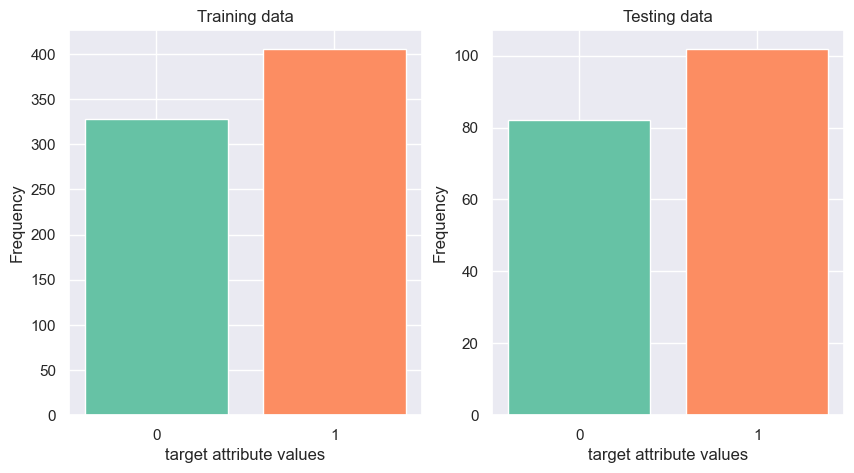

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

values, counts = np.unique(y_train, return_counts=True)
ax[0].bar([str(x) for x in values], counts, color=colour)
ax[0].set_xlabel("target attribute values")
ax[0].set_ylabel("Frequency")
ax[0].set_title("Training data")


values, counts = np.unique(y_test, return_counts=True)
ax[1].bar([str(x) for x in values], counts, color=colour)
ax[1].set_xlabel("target attribute values")
ax[1].set_ylabel("Frequency")
ax[1].set_title("Testing data")

Since our dataset did not have a balanced target value (more patients were diagnosed with heart disease), we had to ensure, that our train and test split would not influence the distribution ie. both parts would be as close as possible with distribution of our target variable. For this we used an optional parameter `stratify` with our target value. As shown in the figure above, this ensured optimal distribution of the value in both sets.

### Attribute Recoding
Since sklearn only accepts numerical input, we will have to recode our categorical attributes into numerical ones.

For categorical variables with multiple categories, we will use `pandas.get_dummies()` function from Pandas. The function automatically transforms all desired categorical columns into binary attributes using One-Hot encoding. This operation will therefore create new columns and drop the old one.

For binary attributes we will have to replace string values such as F/M with numbers using a mappings that will be passed as parameters into `pandas.DataFrame.replace()` method.

In [24]:
X_train = pd.get_dummies(X_train, columns=['ChestPainType', 'RestingECG', 'ST_Slope', ])
X_test = pd.get_dummies(X_test, columns=['ChestPainType', 'RestingECG', 'ST_Slope', ])

In [25]:
sex_mapping = {
    'F': 0,
    'M': 1,
}
angina_mapping = {
    'N': 0,
    'Y': 1,
}

In [26]:
X_train['Sex'] = X_train['Sex'].replace(sex_mapping)
X_train['ExerciseAngina'] = X_train['ExerciseAngina'].replace(angina_mapping)

In [27]:
X_test['Sex'] = X_test['Sex'].replace(sex_mapping)
X_test['ExerciseAngina'] = X_test['ExerciseAngina'].replace(angina_mapping)

In [28]:
X_train[:5]

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
485,63,1,139,217,1,128,1,1.2,False,True,False,False,False,False,True,False,True,False
486,55,1,110,214,1,180,0,0.4,False,True,False,False,False,False,True,False,False,True
117,59,0,130,338,1,130,1,1.5,True,False,False,False,False,False,True,False,True,False
361,47,1,160,0,0,124,1,0.0,True,False,False,False,False,True,False,False,True,False
296,50,1,145,0,1,139,1,0.7,True,False,False,False,False,True,False,False,True,False


In [29]:
X_test[:5]

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
356,46,1,115,0,0,113,1,1.5,True,False,False,False,False,True,False,False,True,False
763,58,1,132,224,0,173,0,3.2,False,False,True,False,True,False,False,False,False,True
817,60,1,125,258,0,141,1,2.8,True,False,False,False,True,False,False,False,True,False
735,49,1,120,188,0,139,0,2.0,False,False,True,False,False,True,False,False,True,False
892,39,0,138,220,0,152,0,0.0,False,False,True,False,False,True,False,False,True,False


Using the control print statements, we can see that all of the values in the table are numerical, therefore acceptable by sklearn models.

### Handling Outliers

Let's once again check how many zeros there are in Cholesterol attribute.

In [30]:
cholesterol = (df['Cholesterol'] == 0).sum()
cholesterol

172

However, we do not want to remove all 172 rows from the dataset. We will therefore use value imputation. We will calculate median of cholesterol and impute this value instead of zeros. Median is better in this scenario instead of mean, since median is more robust to outliers.

For imputing, we will use pandas method `replace()`.

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.replace.html

**Note: since we have established that cholesterol cannot be 0, and therefore there was clearly some error while coding the dataset, we will treat this as handling a missing value.**

In [31]:
impute_value_cholesterol = X_train['Cholesterol'].median()
impute_value_cholesterol

225.0

In [32]:
X_train['Cholesterol'] = X_train['Cholesterol'].replace(0, impute_value_cholesterol)
X_test['Cholesterol'] = X_test['Cholesterol'].replace(0, impute_value_cholesterol)

In [33]:
chol_train = (X_train['Cholesterol'] == 0).sum()
chol_test = (X_test['Cholesterol'] == 0).sum()
print(f'Number of cholesterol zeroes in train: {chol_train}' + f'\nNumber of cholesterol zeroes in test: {chol_test}')

Number of cholesterol zeroes in train: 0
Number of cholesterol zeroes in test: 0


In [34]:
print(X_train["Cholesterol"].isna().sum(), X_test["Cholesterol"].isna().sum()) 

0 0


Now our train and test sets do not contain any zero cholesterol values.

Other cholesterol values, even if they can seem extreme (>600) can be physiologically possible so we won't be removing them.

We previously mentioned that blood pressure also cannot be 0 and since we found 1 value that is equal to 0, we will have to deal with it. We will use the same method by imputing the zero value with train median.

In [35]:
restingBP = (df['RestingBP'] == 0).sum()
restingBP

1

In [36]:
impute_value_restingBP = X_train['RestingBP'].median()
impute_value_restingBP

130.0

In [37]:
X_train['RestingBP'] = X_train['RestingBP'].replace(0, impute_value_restingBP)
X_test['RestingBP'] = X_test['RestingBP'].replace(0, impute_value_restingBP)

In [38]:
rest_train = (X_train['RestingBP'] == 0).sum()
rest_test = (X_test['RestingBP'] == 0).sum()
print(f'Number of RestingBP zeroes in train: {rest_train}' + f'\nNumber of RestingBP zeroes in test: {rest_test}')

Number of RestingBP zeroes in train: 0
Number of RestingBP zeroes in test: 0


### Data Normalization
The goal of normalization is to change the values of numeric columns in the dataset to a common scale, without distorting differences in the ranges of values.
It is a necessity to normalize our data because of the different ranges. In our case, features which were One-Hot encoded would be almost unusable, given that other features such as cholesterol reach values of 600. 

Without normalization, feature cholesterol could be for some tasks (but not for all) almost 600 times more important than Chest pain type and other One-Hot encoded features, which is obviously false.

Normalizing our data should **not** hurt performance in algorithms that do not relly on distances and should improve performance in others. This claim will be backed up by using both normalized and original data.

In [39]:
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [40]:
X_train_scaled[0]

array([ 0.9700116 ,  0.51740017,  0.3390158 , -0.47083454,  1.83549656,
       -0.32451998,  1.20277457,  0.31704567, -1.10341409,  2.0969165 ,
       -0.51740017, -0.24007684, -0.49829642, -1.24799491,  2.05077394,
       -0.26155954,  0.98110491, -0.86224587])

Control print statement shows us that StandardScaler successfully scaled the features by removing the mean and scaling them to unit variance.

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

## 4. Modeling
This chapter focuses on the modeling of classification methods.

We will use and compare two different algorithms:
- Logistic Regression
- Decision Tree Classifier

We will also utilize cross validation and hyperparameter tuning.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

### Logistic Regression
Logistic regression is a statistical method for modeling the relationship between a binary dependent variable and one or more independent variables. Logistic regression predicts the probability that an instance belongs to a particular class. It accomplishes this using the logistic function (also known as the sigmoid function), which maps any real-valued number to a value between 0 and 1. 

In our case we try to predict if patient with given characteristics (features) likely has a heart disease. Firstly, we showcase the impact of number of iterations and normalization. Afterwards we discuss the importance of individual features, and we try hyper parameter tuning, which in case of logistic regresion is L1 and L2 regularization.

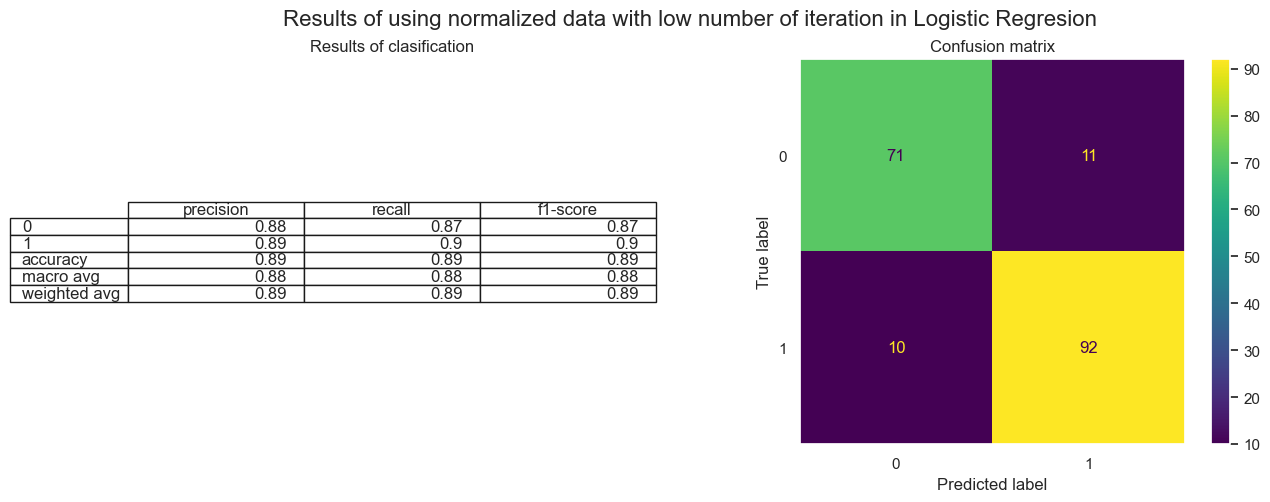


Logistic Regression with normalized features does not need many iterations to achieve good results. This showcases the importance of normalization. Logistic regression with non-normalized features achieves way worse results as we can see in the figure below. Although we need to keep in mind, that the number of iterations was extremely low, and convergence was not guaranteed.



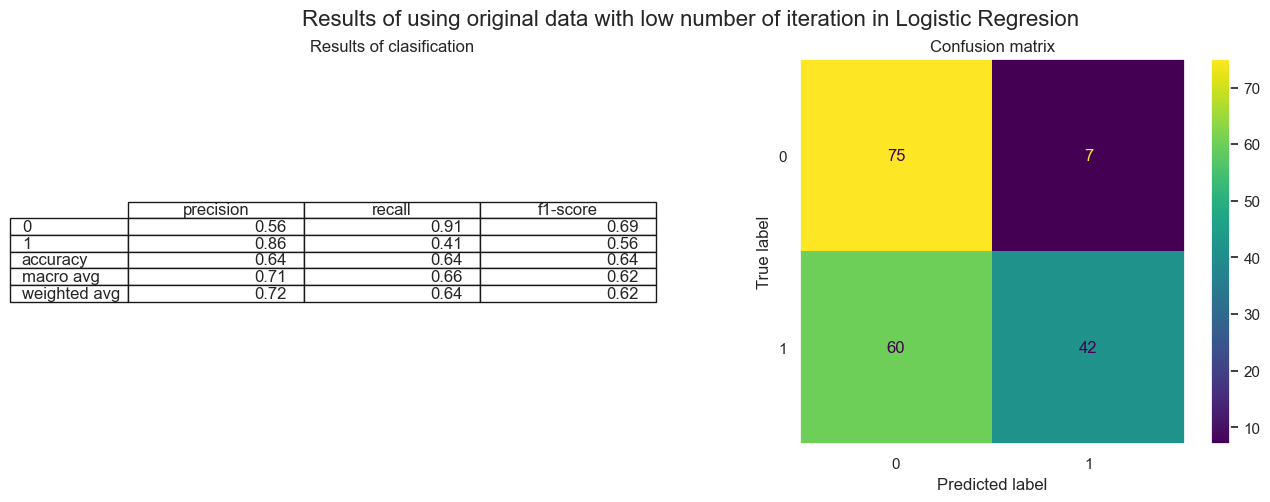

In [44]:
model_lr_low_iter = LogisticRegression(max_iter=5)
model_lr_low_iter_scaled = LogisticRegression(max_iter=5)

model_lr_low_iter_scaled.fit(X_train_scaled, y_train)
y_predict_norm = model_lr_low_iter_scaled.predict(X_test_scaled)
report = pd.DataFrame(classification_report(y_test, y_predict_norm, output_dict=True)).iloc[:-1, :].T

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

fig.suptitle("Results of using normalized data with low number of iteration in Logistic Regresion", fontsize=16)

ax[0].table(cellText=report.values.round(2), colLabels=report.columns, rowLabels=report.index, loc="center")
ConfusionMatrixDisplay.from_estimator(model_lr_low_iter_scaled, X_test_scaled, y_test, ax=ax[1])

ax[0].set_title("Results of clasification")
ax[1].set_title("Confusion matrix")
ax[0].axis("off")
ax[1].grid(False)
plt.show()

print("\nLogistic Regression with normalized features does not need many iterations to achieve good results. This showcases the importance of normalization. Logistic regression with non-normalized features achieves way worse results as we can see in the figure below. Although we need to keep in mind, that the number of iterations was extremely low, and convergence was not guaranteed.\n")

model_lr_low_iter.fit(X_train, y_train)
y_predict = model_lr_low_iter.predict(X_test)
report = pd.DataFrame(classification_report(y_test, y_predict, output_dict=True)).iloc[:-1, :].T

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

fig.suptitle("Results of using original data with low number of iteration in Logistic Regresion", fontsize=16)

ax[0].table(cellText=report.values.round(2), colLabels=report.columns, rowLabels=report.index, loc="center")
ConfusionMatrixDisplay.from_estimator(model_lr_low_iter, X_test, y_test, ax=ax[1])

ax[0].set_title("Results of clasification")
ax[1].set_title("Confusion matrix")
ax[0].axis("off")
ax[1].grid(False)
plt.show()


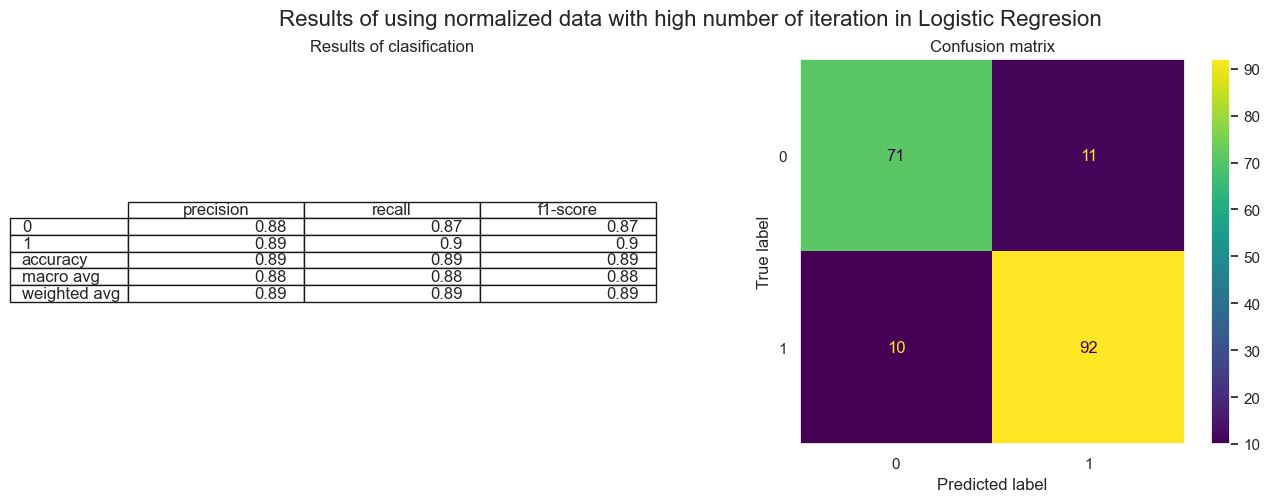


With higher number of iterations, both variants achieve nearly the same result. The model with normalised inputs is a bit better in identifying TN and FP values, while the one without normalization is a bit better in TP and FN. Although we can argue that in the context of classification heart disease, it is very important to minimise false negative classifications, we will still use normalized data in hyper parameter tuning, because some of the solvers work way faster this way and the differences in FN are negligible. 



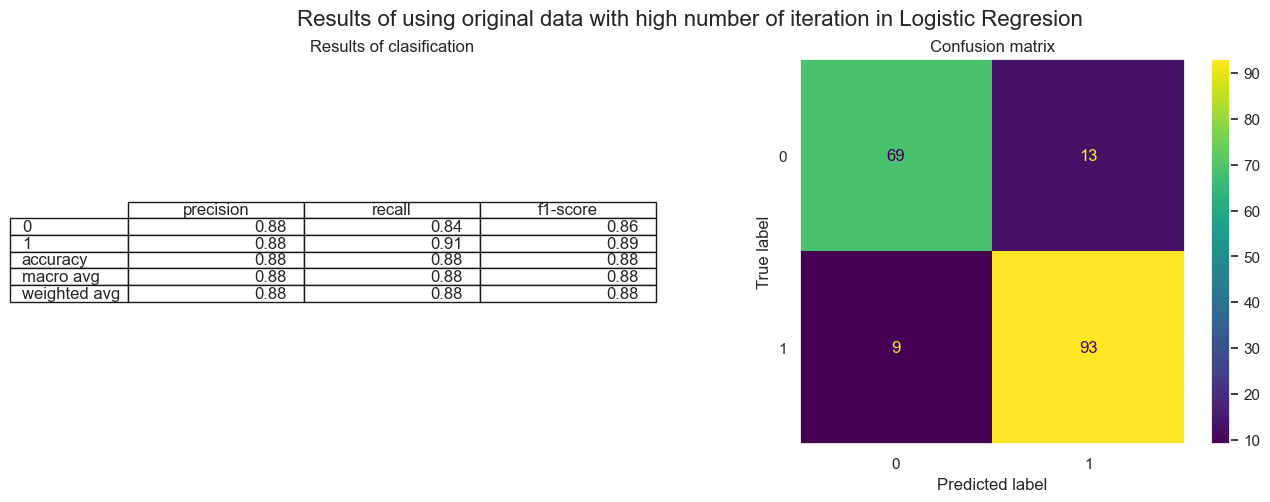

In [46]:
model_lr = LogisticRegression(max_iter=10000)
model_lr_scaled = LogisticRegression(max_iter=10000)

model_lr_scaled.fit(X_train_scaled, y_train)
y_predict_norm = model_lr_scaled.predict(X_test_scaled)
report = pd.DataFrame(classification_report(y_test, y_predict_norm, output_dict=True)).iloc[:-1, :].T

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

fig.suptitle("Results of using normalized data with high number of iteration in Logistic Regresion", fontsize=16)

ax[0].table(cellText=report.values.round(2), colLabels=report.columns, rowLabels=report.index, loc="center")
ConfusionMatrixDisplay.from_estimator(model_lr_scaled, X_test_scaled, y_test, ax=ax[1])

ax[0].set_title("Results of clasification")
ax[1].set_title("Confusion matrix")
ax[0].axis("off")
ax[1].grid(False)
plt.show()

print("\nWith higher number of iterations, both variants achieve nearly the same result. The model with normalised inputs is a bit better in identifying TN and FP values, while the one without normalization is a bit better in TP and FN. Although we can argue that in the context of classification heart disease, it is very important to minimise false negative classifications, we will still use normalized data in hyper parameter tuning, because some of the solvers work way faster this way and the differences in FN are negligible. \n")

model_lr.fit(X_train, y_train)
y_predict = model_lr.predict(X_test)
report = pd.DataFrame(classification_report(y_test, y_predict, output_dict=True)).iloc[:-1, :].T

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

fig.suptitle("Results of using original data with high number of iteration in Logistic Regresion", fontsize=16)

ax[0].table(cellText=report.values.round(2), colLabels=report.columns, rowLabels=report.index, loc="center")
ConfusionMatrixDisplay.from_estimator(model_lr, X_test, y_test, ax=ax[1])

ax[0].set_title("Results of clasification")
ax[1].set_title("Confusion matrix")
ax[0].axis("off")
ax[1].grid(False)
plt.show()


#### Normalization of input data and its impact on number of iterations in logistic regresion
As we showcased earlier, normalization is not mandatory, but it helps model performance. The main benefit is that it lowers the number of iterations required to achieve optimal results. While in case of our dataset this does not matter time wise that much, if we would be working with bigger datasets, it would save us a lot of time. Even more importantly, some solvers heavily prefer scaled data and work way better with them. This is not our case, since default solver is "lbfgs", but it is important to keep this in mind.

#### Importance of individual features
In the figure below we showcase in which way our features affect Logistic regression results. As expected from our previous analysis, being a man has significant impact on our classification. Other significant factors are blood sugar while fasting above 120 mg/dl and asymptomatic pain in chest while working or exercising. All of the patients with these features are more likely to be classified as having a heart disease. Surprisingly age of the patient does not play crucial role. 

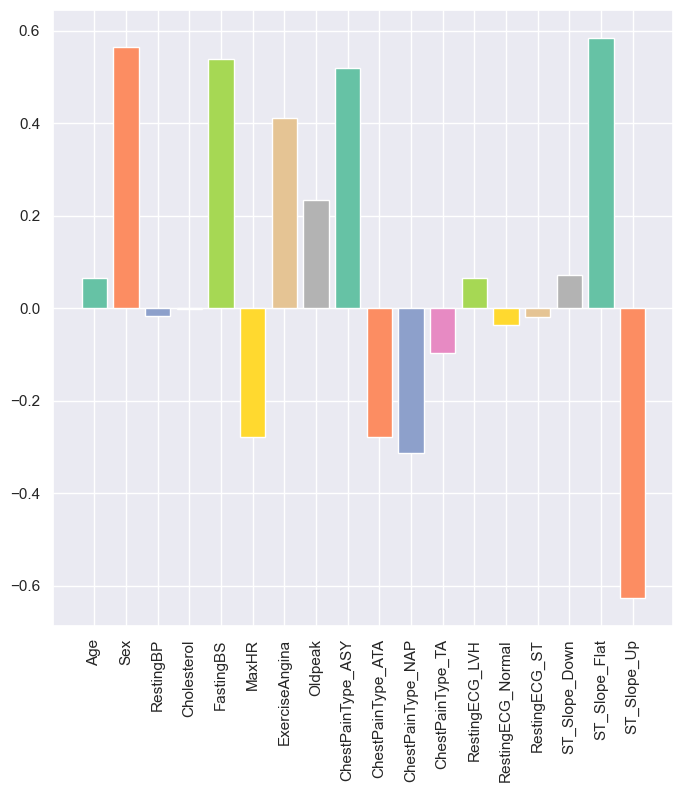

In [47]:
fig, ax = plt.subplots(figsize=(8, 8))

plt.bar(X_train.columns, model_lr_scaled.coef_[0], color=colour)
plt.xticks(rotation=90)
plt.show()

#### Hyperparameter tuning
When it comes to hyperparameter tuning in logistic regression, there is not much we can do. We can specify which regularization will be used (L1, L2, both or none) and its strength. We also experiment with optimal solver for our problem. This kind of pushes us to use scaled data, since we want to try most of them. As for selecting our scoring method, we stick to f1 as we want to minimise false negatives which are very important to us, but we also want to keep fairly high precision. 

After specifying our parameters we start the search and after a minute or two, we get the best parameters that the algorithm found. 

In [48]:
parameters = {"C":np.logspace(-4, 4, num=20), 
              "penalty":["l1", "l2"], #There are more options availible ("elasticnet" - both L1 and L2, "None") but we are limited by time of execution, and our prior runes never selected those penalties.
              "max_iter": [10000],
              "solver":["lbfgs", "liblinear", "sag", "saga"]} #Same goes for solvers, we removed "newton-cg" and "newton-cholesky" to save a bit of time.

lr = LogisticRegression()


grid_search = GridSearchCV(estimator = lr,  
                           param_grid = parameters,
                           scoring = 'f1',
                           cv = 10,
                           verbose=1)
grid_search.fit(X_train_scaled, y_train)
print(grid_search.best_params_)



Fitting 10 folds for each of 160 candidates, totalling 1600 fits
{'C': 0.0018329807108324356, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'lbfgs'}


Then all we need to do is pass those parameters to logistic regression and train it on the full training data. The best parameters that were found during the constrained search are printed above. Interestingly, the default solver was chosen as the best.

In [49]:
lr_gs = LogisticRegression(**grid_search.best_params_)
lr_gs.fit(X_train_scaled, y_train)
y_predict_gs = lr_gs.predict(X_test_scaled)

After training, we can finally display our results. As we can see our model improved in terms of false negatives by one patient who was now correctly labelled. 

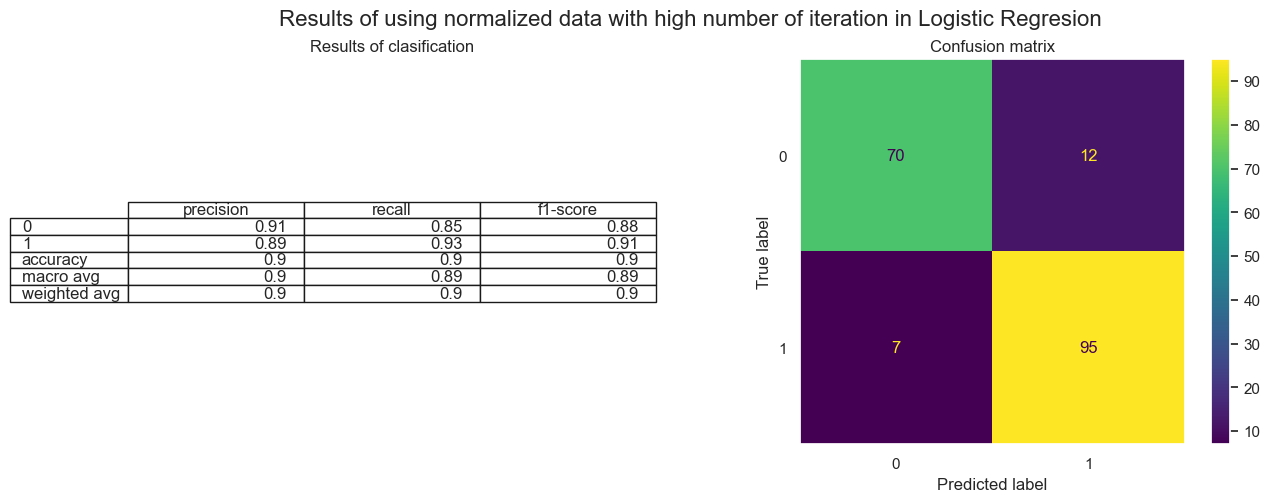

In [50]:
report = pd.DataFrame(classification_report(y_test, y_predict_gs, output_dict=True)).iloc[:-1, :].T

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

fig.suptitle("Results of using normalized data with high number of iteration in Logistic Regresion", fontsize=16)

ax[0].table(cellText=report.values.round(2), colLabels=report.columns, rowLabels=report.index, loc="center")
ConfusionMatrixDisplay.from_estimator(lr_gs, X_test_scaled, y_test, ax=ax[1])

ax[0].set_title("Results of clasification")
ax[1].set_title("Confusion matrix")
ax[0].axis("off")
ax[1].grid(False)
plt.show()

After HP tunning we can see difference in coefficients. Although the directions of coefficient remain unchanged, their values are smaller.

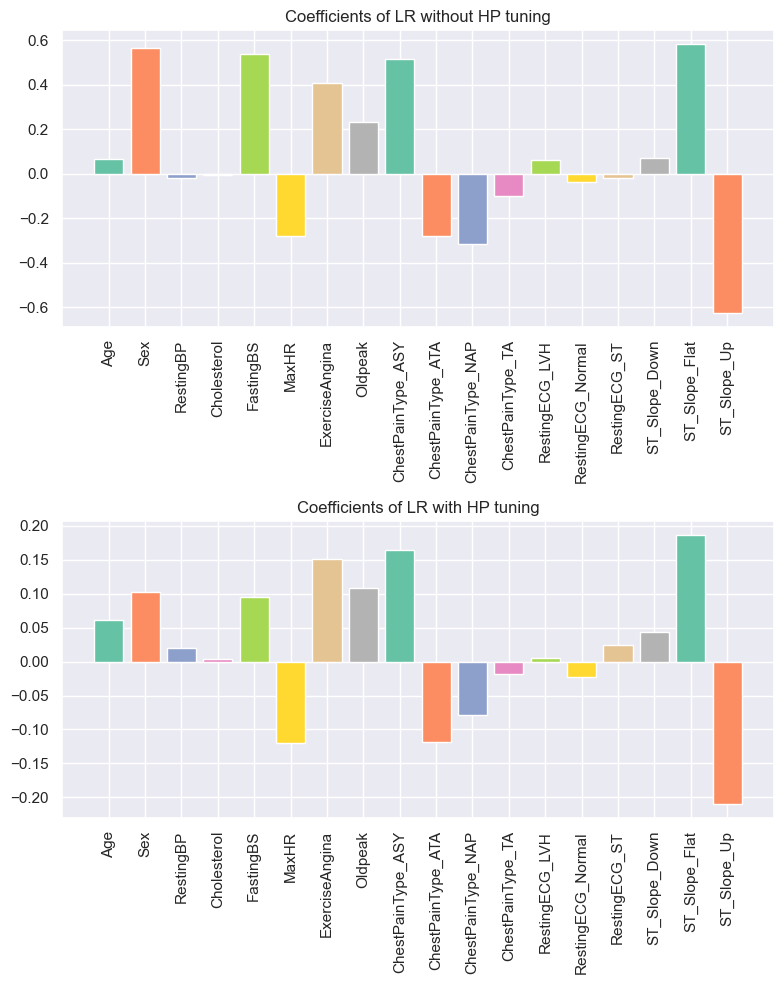

In [51]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 10))

ax[0].bar(X_train.columns, model_lr_scaled.coef_[0], color=colour)
ax[0].tick_params(axis='x', labelrotation=90)
ax[0].set_title("Coefficients of LR without HP tuning")

ax[1].bar(X_train.columns, lr_gs.coef_[0], color=colour)
ax[1].tick_params(axis='x', labelrotation=90)
ax[1].set_title("Coefficients of LR with HP tuning")

plt.tight_layout()
plt.show()

### Decision Tree Classifier

Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation.

`DecisionTreeClassifier` is a class capable of performing multi-class classification on a dataset.

As with other classifiers, `DecisionTreeClassifier` takes as input two arrays: an array X, sparse or dense, of shape `(n_samples, n_features)` holding the training samples, and an array Y of integer values, shape `(n_samples,)`, holding the class labels for the training sample.

<function matplotlib.pyplot.show(close=None, block=None)>

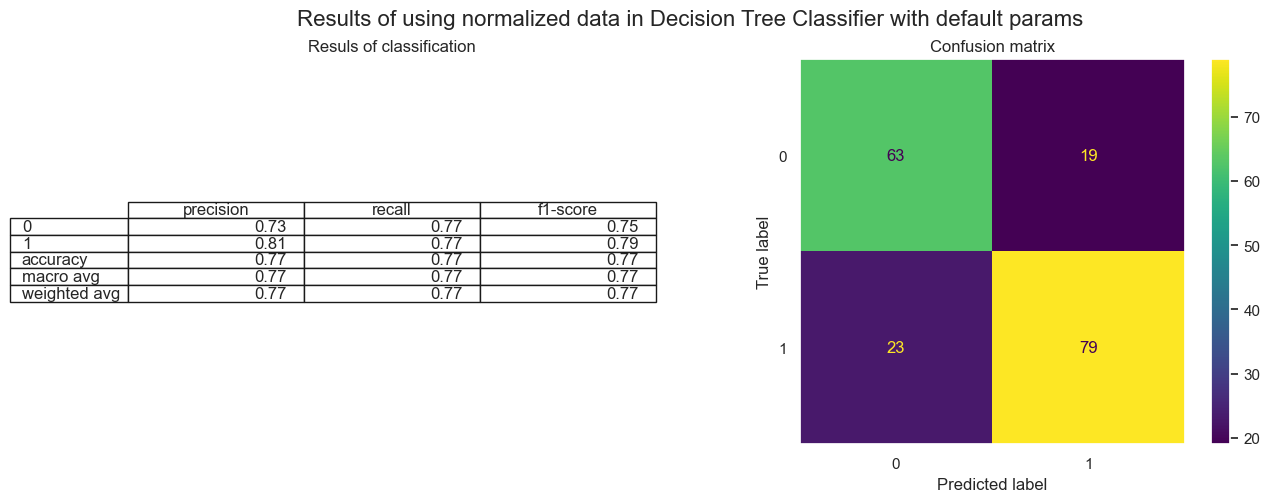

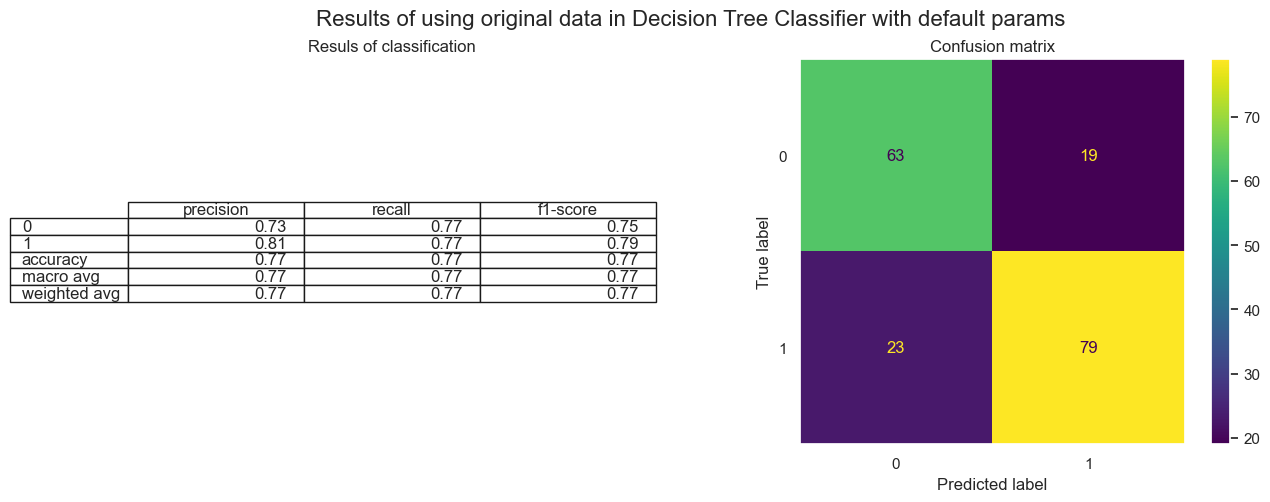

In [52]:
model_dt_default_scaled = DecisionTreeClassifier(random_state=42)

model_dt_default_scaled.fit(X_train_scaled, y_train)
y_pred_dt_default_scaled = model_dt_default_scaled.predict(X_test_scaled)
report = pd.DataFrame(classification_report(y_test, y_pred_dt_default_scaled, output_dict=True)).iloc[:-1, :].T

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

fig.suptitle("Results of using normalized data in Decision Tree Classifier with default params", fontsize=16)

ax[0].table(cellText=report.values.round(2), colLabels=report.columns, rowLabels=report.index, loc="center")
ConfusionMatrixDisplay.from_estimator(model_dt_default_scaled, X_test_scaled, y_test, ax=ax[1])

ax[0].set_title("Resuls of classification")
ax[1].set_title("Confusion matrix")
ax[0].axis("off")
ax[1].grid(False)
plt.show

model_dt_default = DecisionTreeClassifier(random_state=42)

model_dt_default.fit(X_train, y_train)
y_pred_dt_default = model_dt_default.predict(X_test)
report = pd.DataFrame(classification_report(y_test, y_pred_dt_default, output_dict=True)).iloc[:-1, :].T

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

fig.suptitle("Results of using original data in Decision Tree Classifier with default params", fontsize=16)

ax[0].table(cellText=report.values.round(2), colLabels=report.columns, rowLabels=report.index, loc="center")
ConfusionMatrixDisplay.from_estimator(model_dt_default, X_test, y_test, ax=ax[1])

ax[0].set_title("Resuls of classification")
ax[1].set_title("Confusion matrix")
ax[0].axis("off")
ax[1].grid(False)
plt.show

As we can see from the results, the normalization doesn't have an effect on this default, non-tunned decision tree. The accuracy is identical. The model also gives way worse results than Logistic Regression, where the accuracy is only 77 %.

Let's now create a figure of the decision tree from one of the models.

In [53]:
model_dt_default_scaled.get_depth()

12

From the method `get_depth()` we can see that the tree is going to have a depth of 12, which will result in a fairly large tree which might be hard to read.

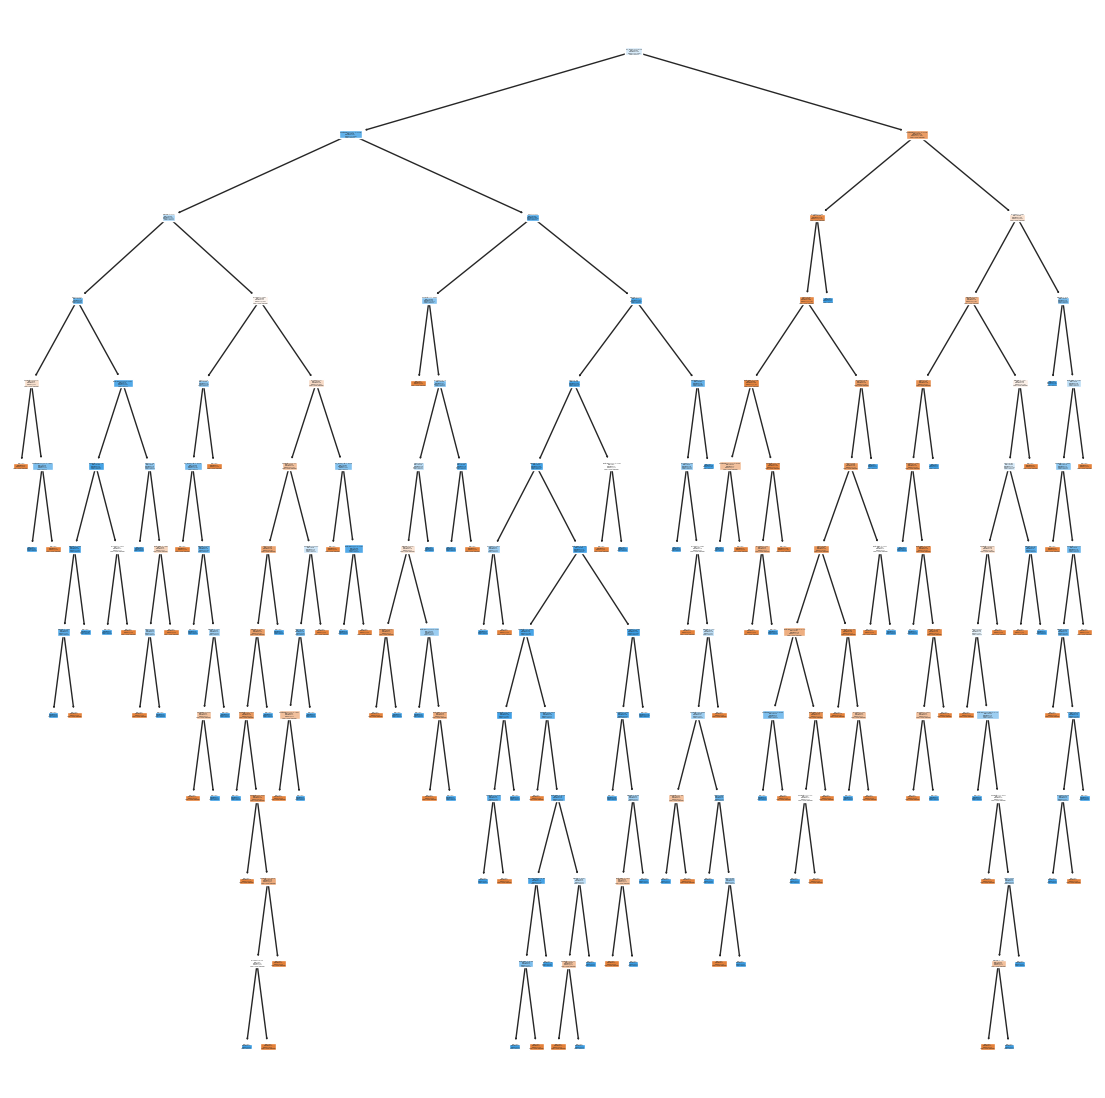

In [54]:
plt.figure(figsize=(14,14))
plot_tree(
    model_dt_default_scaled,
    feature_names=list(X_train.columns),
    class_names=["Heart disease", "normal"],
    filled= True,
)
plt.show()

In [55]:
model_dt_default_scaled.get_params().get('criterion')

'gini'

Let's look at what default criterion was used by the decision tree and visualize feature importance of this model.

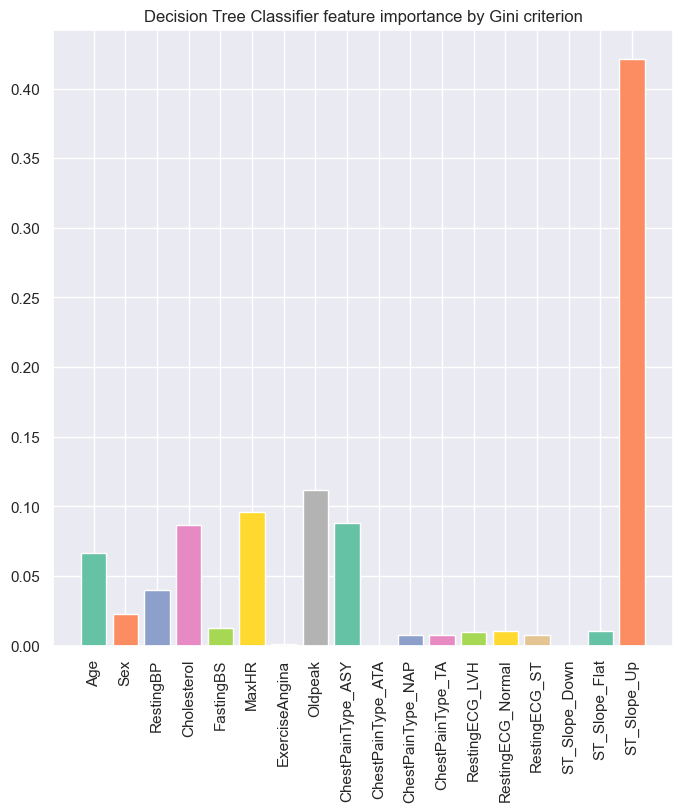

In [56]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.bar(X_train.columns, model_dt_default_scaled.feature_importances_, color=colour)
plt.xticks(rotation=90)
plt.title('Decision Tree Classifier feature importance by Gini criterion')
plt.show()

Seems like attribute ST_Slope_UP is the most important for this classifier, while various types of ChestPain do not play an important role while training. Other features have low to very low importance.

We will need to use hyperparameter tunning to get tree with better results.

#### Hyperparameter tunning and model optimatizion

First, let's create a grid object with all the possible values of parameters we're going to be searching for.

In [57]:
dt_param_grid = {
    "criterion": ("gini", "entropy"),
    "max_depth": tuple(range(3, 14)),
    "max_features": ("sqrt", "log2"),
    "min_samples_leaf": (1, 2, 3, 4),
    "min_samples_split": (2, 3, 4),
    "ccp_alpha": (0.001, 0.01, 0.1)
}

We are going to create a `GridSearchCV` object, that will find the optimal values for all parameters in the grid. After that, we're going to train a new model on those optimized parameters. For training, we are going to use a 10 fold cross-validation.

In [58]:
dt_tunned = DecisionTreeClassifier(random_state=42)

dt_grid_cv = GridSearchCV(dt_tunned, dt_param_grid, cv=10, verbose=True)
dt_grid_cv.fit(X_train_scaled, y_train)

Fitting 10 folds for each of 1584 candidates, totalling 15840 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'ccp_alpha': (0.001, 0.01, 0.1),
                         'criterion': ('gini', 'entropy'),
                         'max_depth': (3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13),
                         'max_features': ('sqrt', 'log2'),
                         'min_samples_leaf': (1, 2, 3, 4),
                         'min_samples_split': (2, 3, 4)},
             verbose=True)

After fitting the GridSearchCV object, let's look at the best possible parameters we can use to fit our new decision tree.

In [59]:
dt_grid_cv.best_params_

{'ccp_alpha': 0.001,
 'criterion': 'entropy',
 'max_depth': 4,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2}

We are now going to use these parameters in a new decision tree, which we will fit on our scaled training data and evaluate the results on a scaled test set.

In [60]:
dt_final = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=4,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    ccp_alpha = 0.001,
    random_state=42,
)
dt_final.fit(X_train_scaled, y_train)
y_pred_dt_final = dt_final.predict(X_test_scaled)

<function matplotlib.pyplot.show(close=None, block=None)>

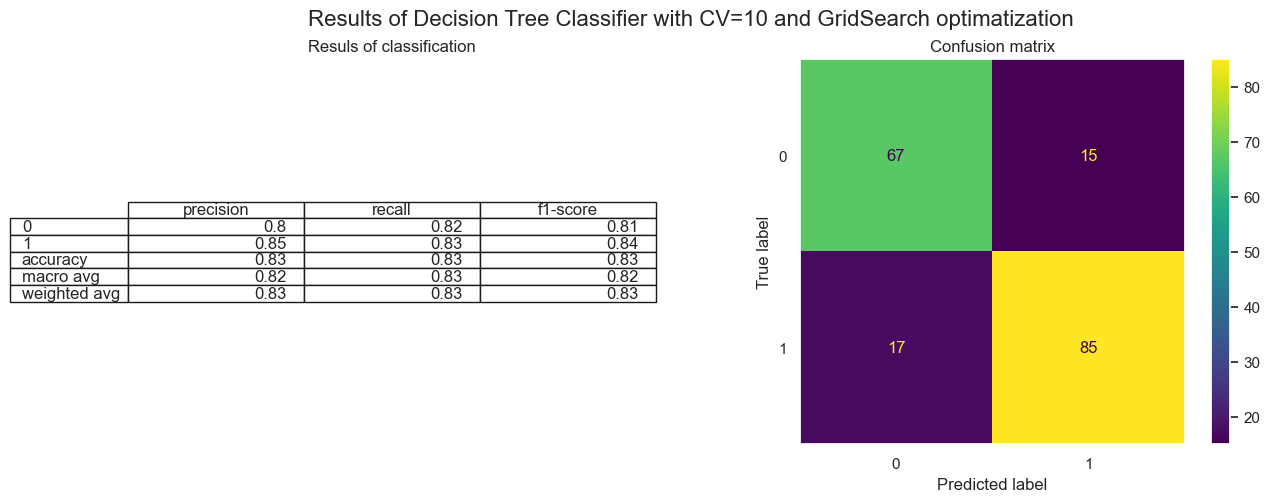

In [61]:
report = pd.DataFrame(classification_report(y_test, y_pred_dt_final, output_dict=True)).iloc[:-1, :].T

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

fig.suptitle("Results of Decision Tree Classifier with CV=10 and GridSearch optimatization", fontsize=16)

ax[0].table(cellText=report.values.round(2), colLabels=report.columns, rowLabels=report.index, loc="center")
ConfusionMatrixDisplay.from_estimator(dt_final, X_test_scaled, y_test, ax=ax[1])

ax[0].set_title("Resuls of classification")
ax[1].set_title("Confusion matrix")
ax[0].axis("off")
ax[1].grid(False)
plt.show

The tunned optimized decision tree achieved an accuracy of 83% on the test data, which is better by 6% from the original tree. We gained a total of 4 more true positives and 6 more true negatives in our confusion matrix.

Let's look at feature importance for this model. This time, we are using entropy as criterion, since it was selected as the best parameter during our grid search.

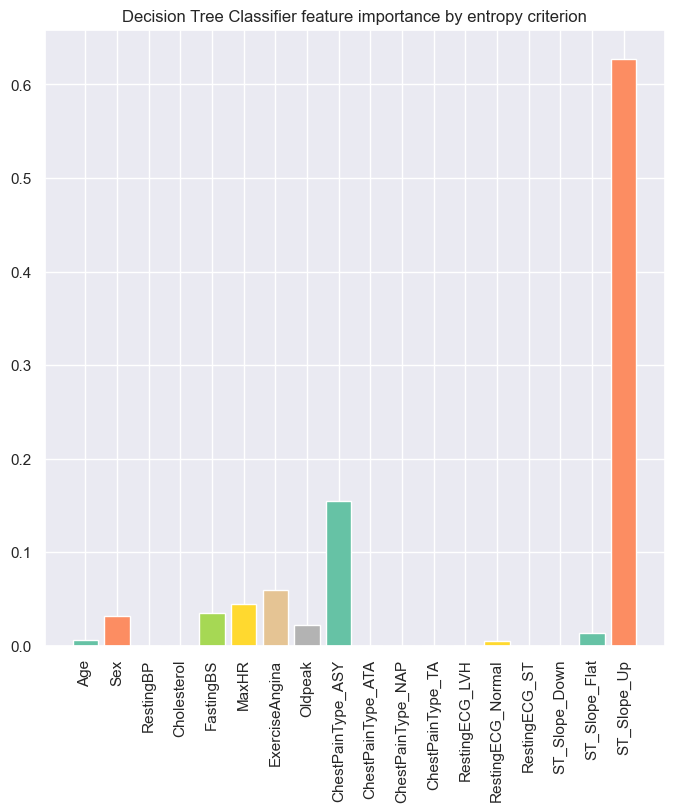

In [62]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.bar(X_train.columns, dt_final.feature_importances_, color=colour)
plt.xticks(rotation=90)
plt.title('Decision Tree Classifier feature importance by entropy criterion')
plt.show()

The results of feature importance are a bit different to the original models. Attribute ST_Slope_Up gained even more importance, while every other attribute decreased dramatically. Only one-hot encoded binary attribute ChestPainType_ATA retained its fairly high importance.

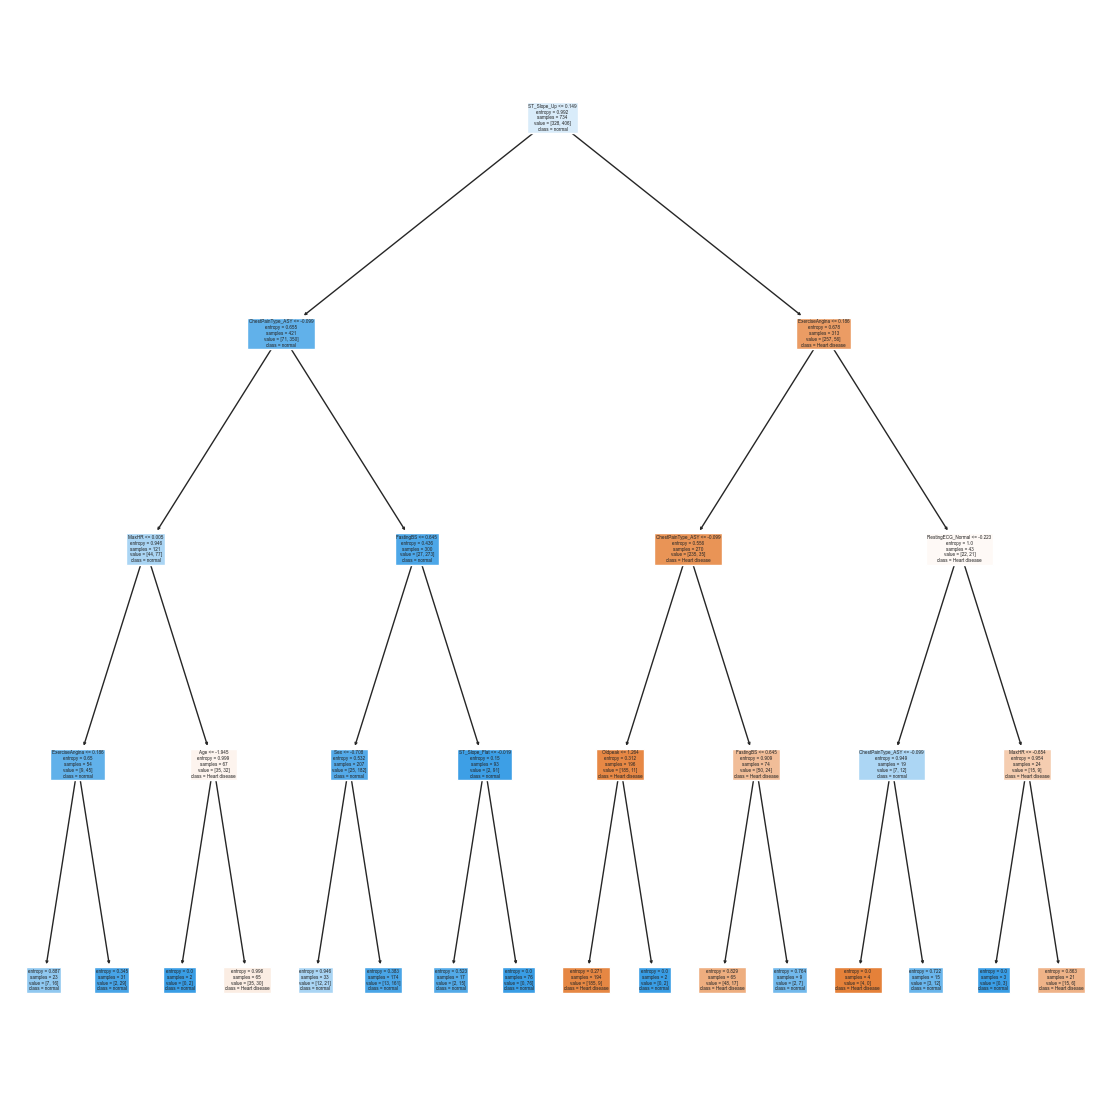

In [63]:
plt.figure(figsize=(14,14))
plot_tree(
    dt_final,
    feature_names=list(X_train.columns),
    class_names=["Heart disease", "normal"],
    filled= True,
)
plt.show()

Here we can see the plotted tree, with a max depth of 4, which is much more nicer to read and easier to explain to others.

This concludes chapter for modeling, where we trained and tunned two different classification models: Logistic Regression and Decision Trees. Now it is time to evaluate those two models and look at the results.

## 5. Results and Evaluation

This chapter focuses on summarizing the models and evaluating their performance.

### Logistic Regression

This section focuses on evaluating the different logistic regression models.

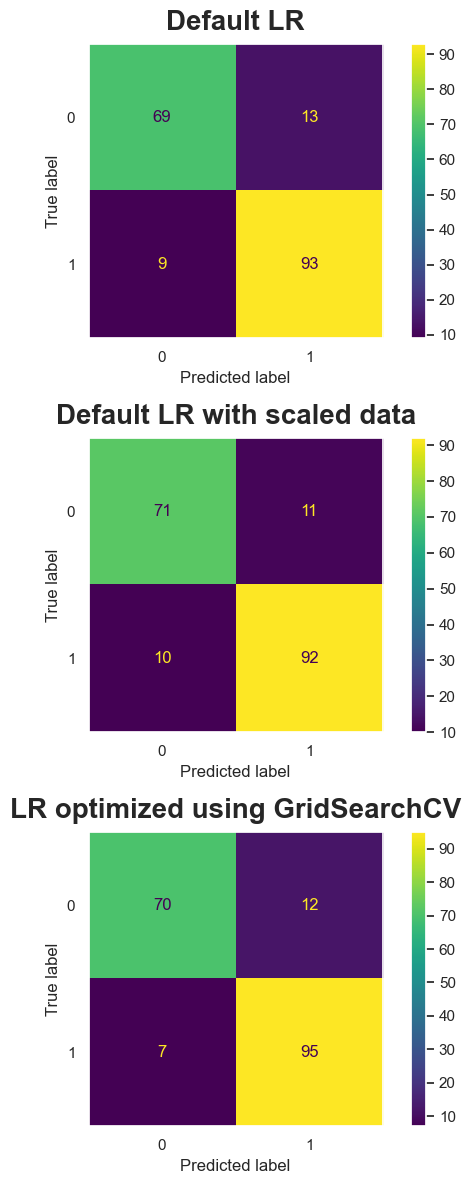

In [64]:
fig, axs = plt.subplots(3, 1, figsize=(6, 12))

ConfusionMatrixDisplay.from_estimator(model_lr, X_test, y_test, ax=axs[0])
axs[0].set_title('Default LR', fontweight='bold', fontsize=20, pad=10)
axs[0].grid(False)

ConfusionMatrixDisplay.from_estimator(model_lr_scaled, X_test_scaled, y_test, ax=axs[1])
axs[1].set_title('Default LR with scaled data', fontweight='bold', fontsize=20, pad=10)
axs[1].grid(False)

ConfusionMatrixDisplay.from_estimator(lr_gs, X_test_scaled, y_test, ax=axs[2])
axs[2].set_title('LR optimized using GridSearchCV', fontweight='bold', fontsize=20, pad=10)
axs[2].grid(False)

plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.show()

Here we can see the different confusion matrices for our logistic regression models. Logistic Regression with scaled data and HP comes out as the best model. It minimises the number of FN (very important) and it achieves great accuracy and precision. All computed metrics are shown below. 

In [65]:
predict_data = {"lr_default":y_predict,
                "lr_scaled":y_predict_norm, 
                "lr_optimized":y_predict_gs
               }
print("-------------------------------")
for model, predictions in predict_data.items():
    print(f"{model} - accuracy: {round(accuracy_score(y_test, predictions),2)}")
    print(f"{model} - precision: {round(precision_score(y_test, predictions),2)}")
    print(f"{model} - recall: {round(recall_score(y_test, predictions),2)}")
    print(f"{model} - f1-score: {round(f1_score(y_test, predictions),2)}")
    print("-------------------------------")
    
print("The model which was created through HP tuning has the best results across different metrics.")

-------------------------------
lr_default - accuracy: 0.88
lr_default - precision: 0.88
lr_default - recall: 0.91
lr_default - f1-score: 0.89
-------------------------------
lr_scaled - accuracy: 0.89
lr_scaled - precision: 0.89
lr_scaled - recall: 0.9
lr_scaled - f1-score: 0.9
-------------------------------
lr_optimized - accuracy: 0.9
lr_optimized - precision: 0.89
lr_optimized - recall: 0.93
lr_optimized - f1-score: 0.91
-------------------------------
The model which was created through HP tuning has the best results across different metrics.


Let's plot ROC curves for all of the logistic regression models and look at the results. The ROC (Receiver Operating Characteristic) curve is a graphical representation that illustrates the performance of a binary classification model across different threshold values. It plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings.

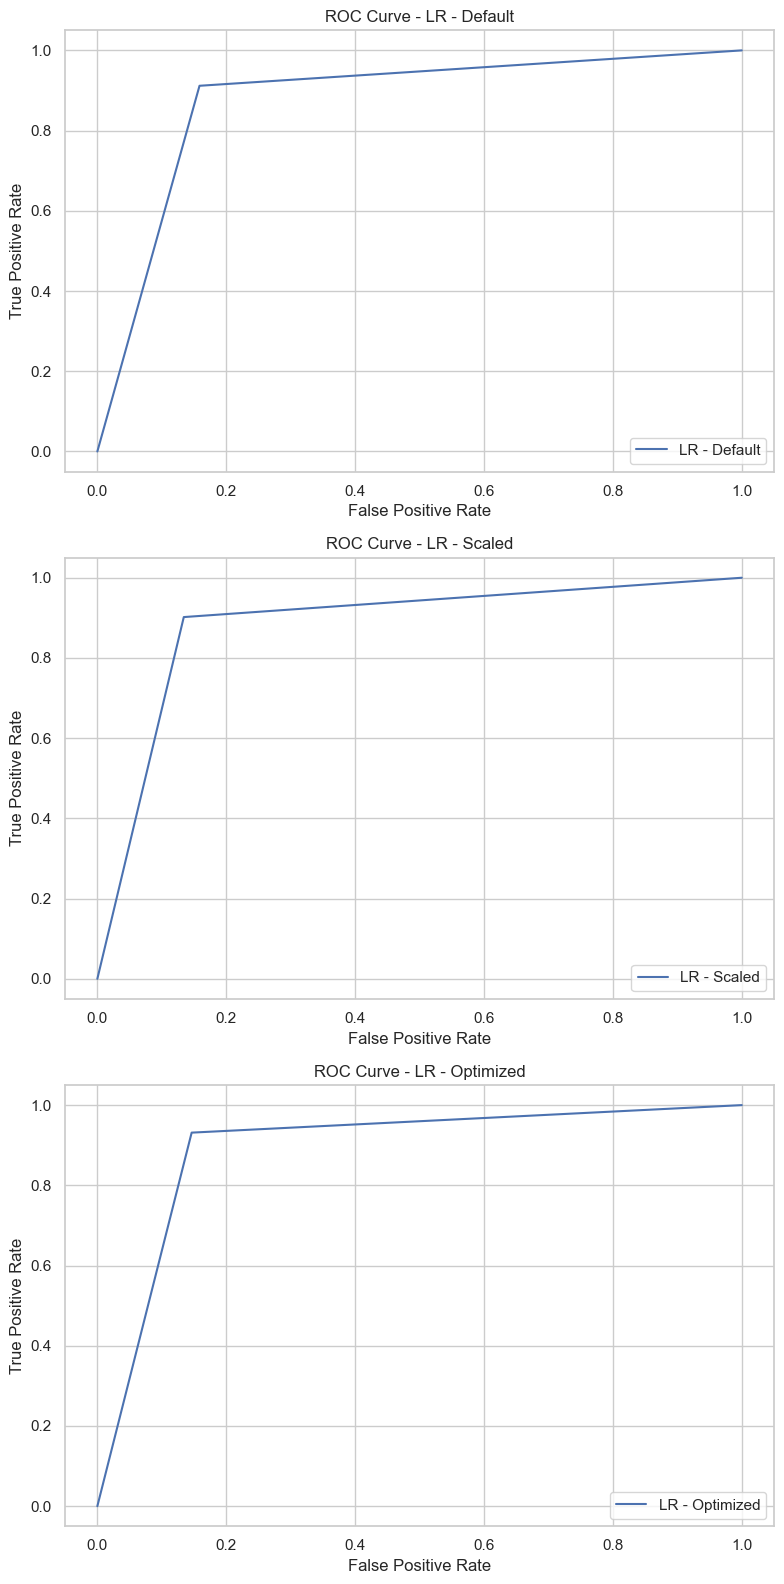

In [73]:
y_preds = [y_predict, y_predict_norm, y_predict_gs]
lrs = ['LR - Default', 'LR - Scaled', 'LR - Optimized']

fig, axs = plt.subplots(3, 1, figsize=(8, 16))

for i, (y_pred, lr) in enumerate(zip(y_preds, lrs)):
    fpr, tpr, _thresholds = roc_curve(y_test, y_pred, pos_label=lr_gs.classes_[1])
    RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=lr).plot(ax=axs[i])
    axs[i].set_title(f'ROC Curve - {lr}')

plt.tight_layout()
plt.show()

From ROC curves, we can now calculate AUC score. The area under the ROC curve (AUC) is commonly used as a summary metric of a model's performance. A higher AUC value indicates better overall performance of the classifier across all possible threshold values, with a maximum value of 1 indicating a perfect (most likely overfitted) classifier.

In [67]:
print(
    "AUC scores:\n",
    roc_auc_score(y_test, y_predict),
    "\n",
    roc_auc_score(y_test, y_predict_norm),
    "\n",
    roc_auc_score(y_test, y_predict_gs))

AUC scores:
 0.8766140602582495 
 0.8839072214251554 
 0.8925155428024868


In conclusion, the best logistic regression model is the one optimized with GridSearchCV, achieving best results in every metric calculated.

### Decision Trees

This section focuses on evaluating the different decision trees.

First, let's display and compare confusion matrices for all 3 decision tree models on the test data.

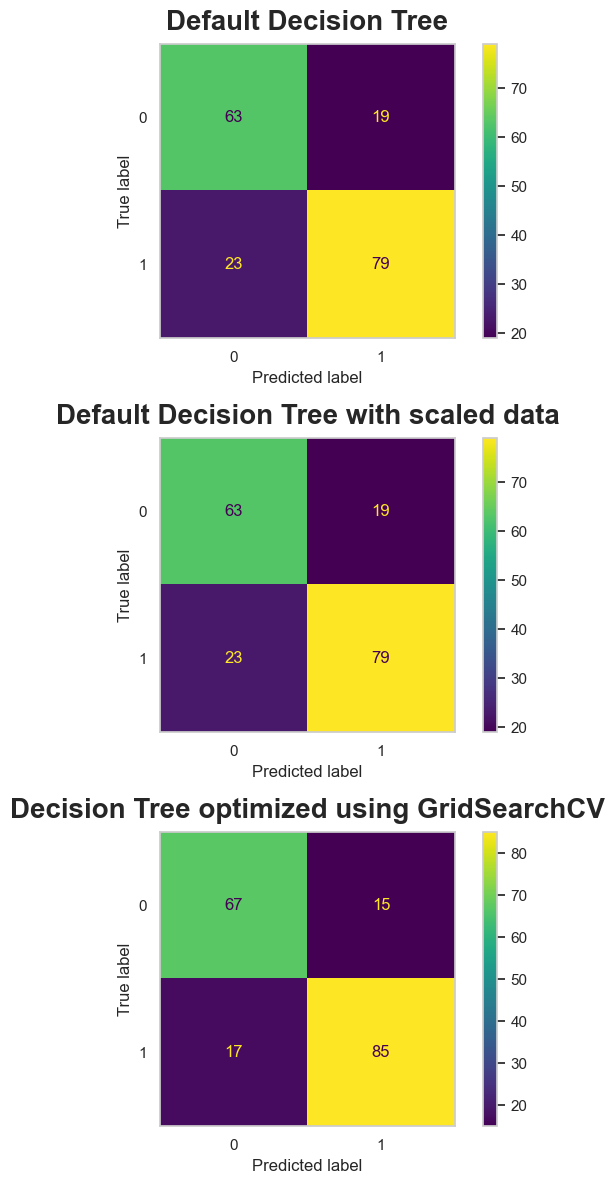

In [69]:
fig, axs = plt.subplots(3, 1, figsize=(6, 12))

ConfusionMatrixDisplay.from_estimator(model_dt_default, X_test, y_test, ax=axs[0])
axs[0].set_title('Default Decision Tree', fontweight='bold', fontsize=20, pad=10)
axs[0].grid(False)

ConfusionMatrixDisplay.from_estimator(model_dt_default_scaled, X_test_scaled, y_test, ax=axs[1])
axs[1].set_title('Default Decision Tree with scaled data', fontweight='bold', fontsize=20, pad=10)
axs[1].grid(False)

ConfusionMatrixDisplay.from_estimator(dt_final, X_test_scaled, y_test, ax=axs[2])
axs[2].set_title('Decision Tree optimized using GridSearchCV', fontweight='bold', fontsize=20, pad=10)
axs[2].grid(False)

plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.show()

By plotting over all 3 confusion matrices, we can see that only the last model improved its performance.

In [70]:
accuracy_scores = {
    "dt_default": accuracy_score(y_test, y_pred_dt_default), 
    "dt_scaled": accuracy_score(y_test, y_pred_dt_default_scaled), 
    "dt_optimized": accuracy_score(y_test, y_pred_dt_final),
}

for acc, i in accuracy_scores.items():
    print(f"{acc} - accuracy: {round(i, 2)}")

dt_default - accuracy: 0.77
dt_scaled - accuracy: 0.77
dt_optimized - accuracy: 0.83


Last decision tree optimized by GridSearchCV has the best accuracy of 83 % on test data.

Now let's plot ROC curve for all 3 decision trees.

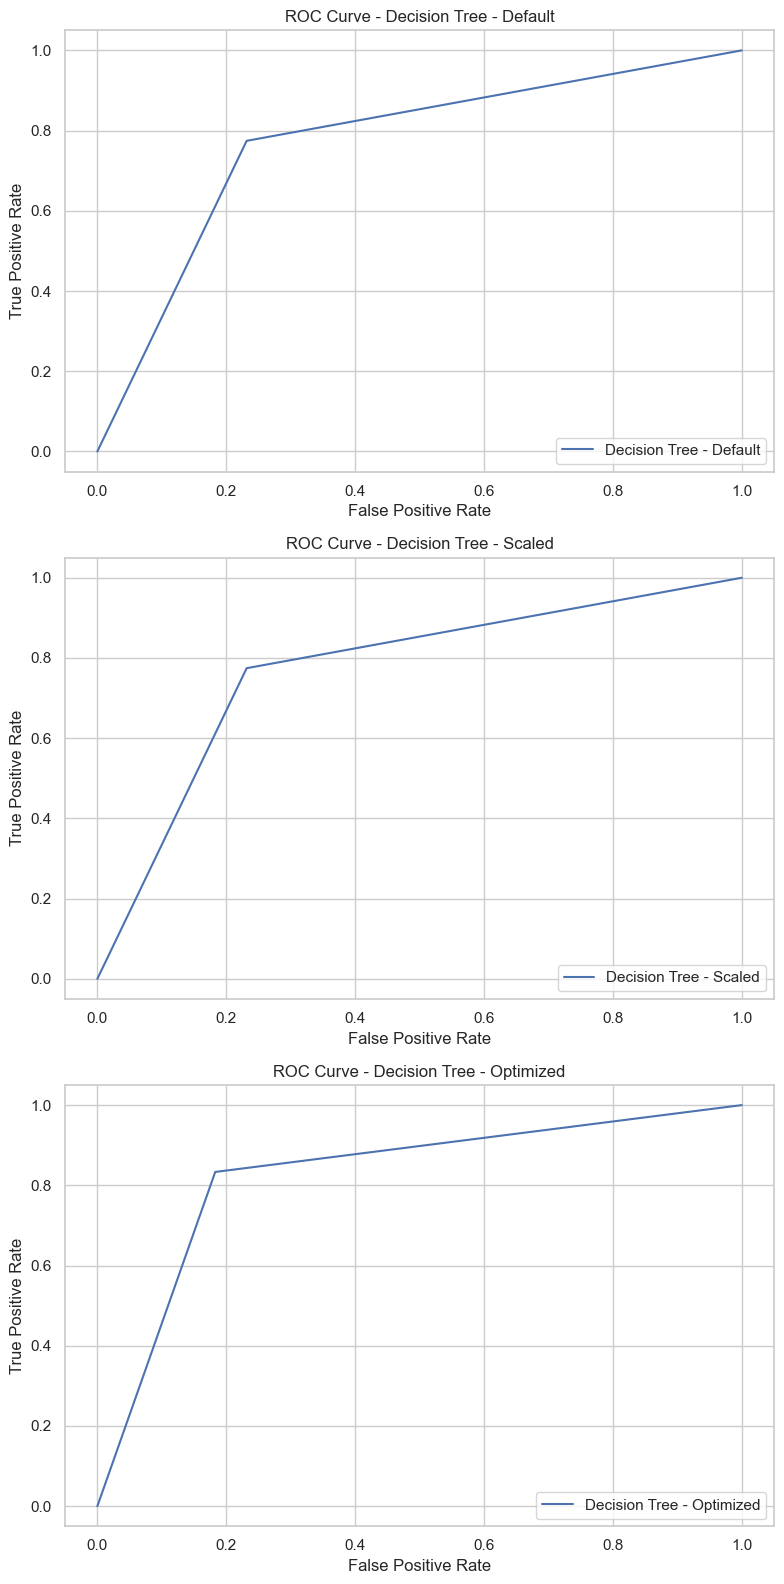

In [74]:
y_preds = [y_pred_dt_default, y_pred_dt_default_scaled, y_pred_dt_final]
trees = ['Decision Tree - Default', 'Decision Tree - Scaled', 'Decision Tree - Optimized']

fig, axs = plt.subplots(3, 1, figsize=(8, 16))

for i, (y_pred, tree) in enumerate(zip(y_preds, trees)):
    fpr, tpr, _thresholds = roc_curve(y_test, y_pred, pos_label=model_dt_default.classes_[1])
    RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=tree).plot(ax=axs[i])
    axs[i].set_title(f'ROC Curve - {tree}')

plt.tight_layout()
plt.show()

From ROC curves, we can now calculate AUC score for each tree.

In [75]:
print(
    "AUC scores:\n",
    roc_auc_score(y_test, y_pred_dt_default),
    "\n",
    roc_auc_score(y_test, y_pred_dt_default_scaled),
    "\n",
    roc_auc_score(y_test, y_pred_dt_final))

AUC scores:
 0.7714012434241989 
 0.7714012434241989 
 0.8252032520325204


In conclusion, the best decision tree is the one optimized with GridSearchCV, achieving best results in every metric calculated.

### Summary of evaluation

As can be seen from the model evaluation, logistic regression was a better algorithm for this binary classification problem than decision trees. Logistic Regression achieved better results than decision trees on every single model, even considering hyperparameter tunning. The best optimized LR model had a accuracy of **90%**, while the best decision tree had a accuracy of **83%**, both on scaled test data.

These results are very good, especially for the logistic regression models considering the size of this dataset.

## 6. Conclusion

In this analysis, our goal was to predict heart disease events on patients using a dedicated dataset of 918 observations with 11 clinical features and 1 target binary variable. Firsty, we introduced and explained the dataset and tried to understand the domain we were working with. Then we performed an exploratory data analysis, where we visualized all features to get a better understanding of the attributes. We found all kinds of interesting facts about the data, which we then used later in the analysis. Next, we carried out preprocessing of our dataset using the pandas library. We had to recode several attributes and deal with outliers and missing/nonsensical data. We also scaled (normalized) the data, so it would be easier to use them in different models. After that, we trained two machine learning models, logistic regression and decision trees on our data. To ensure better results, we also used hyperparameter tunning methods. Lastly, we used these trained models and evaluated their performance on our test set using different evaluation metrics.

Our best model achieved a performance of 90%, so it is safe to say that our analysis was successful, and we can confidently predict heart disease events for about 90% of the patients. Obviously for real world application, this number would need to be even higher, as there is a massive risk by wrongly diagnosing a human being, especially in something like heart diseases. We assume that training a deep neural network would net even better results for this particular task.